# Clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as hc
from sklearn.cluster import KMeans

## Part 1: Data preparation

In [2]:
# Read the data from the file
# Data from https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/12xVojcS_q6kT4pkXmQtQRu_D2P4qaTekLfFMhjrw0qA/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df_all = pd.read_excel('sheet.xlsx')

In [3]:
# Check the first few lines to see the column names and type of content
df_all.head()

,customer_id,tran_amount_2011,tran_amount_2012,tran_amount_2013,tran_amount_2014,tran_amount_2015,transactions_2011,transactions_2012,transactions_2013,transactions_2014,transactions_2015,First_Transaction,Latest_Transaction
0,CS2945,153.0,516.0,173.0,1029.0,40.0,2.0,7.0,3.0,13.0,1.0,2011-05-18 00:00:00,2015-03-08 00:00:00
1,CS4074,269.0,429.0,737.0,1027.0,NaN,3.0,6.0,10.0,15.0,NaN,2011-05-29 00:00:00,05-Dec-14
2,CS4798,153.0,536.0,414.0,1001.0,47.0,2.0,7.0,6.0,11.0,1.0,2011-07-01 00:00:00,2015-02-21 00:00:00
3,CS4424,547.0,380.0,921.0,984.0,101.0,7.0,5.0,13.0,13.0,1.0,2011-05-25 00:00:00,19-Jan-15
4,CS5057,290.0,235.0,509.0,974.0,NaN,4.0,4.0,6.0,12.0,NaN,2011-07-10 00:00:00,02-Dec-14


In [4]:
# Size of the dataframe
df_all.shape

(6889, 13)

In [5]:
# Remove rows with empty values
df_all = df_all.replace(r'^\s*$', float('NaN'), regex = True)
df_all.dropna(inplace = True)
df_all.shape

(3889, 13)

In [6]:
# Let us check the types of the different columns
df_all.dtypes

,0
customer_id,object
tran_amount_2011,float64
tran_amount_2012,float64
tran_amount_2013,float64
tran_amount_2014,float64
tran_amount_2015,float64
transactions_2011,float64
transactions_2012,float64
transactions_2013,float64
transactions_2014,float64


In [7]:
#  Let us adapt the dataframe removing irrelevant variables
df_all = df_all.drop(['First_Transaction', 'Latest_Transaction'], axis = 1)

print('Dataframe df for clustering analysis: ')
df_all

Dataframe df for clustering analysis: 


,customer_id,tran_amount_2011,tran_amount_2012,tran_amount_2013,tran_amount_2014,tran_amount_2015,transactions_2011,transactions_2012,transactions_2013,transactions_2014,transactions_2015
0,CS2945,153.0,516.0,173.0,1029.0,40.0,2.0,7.0,3.0,13.0,1.0
2,CS4798,153.0,536.0,414.0,1001.0,47.0,2.0,7.0,6.0,11.0,1.0
3,CS4424,547.0,380.0,921.0,984.0,101.0,7.0,5.0,13.0,13.0,1.0
5,CS4558,229.0,171.0,378.0,963.0,45.0,3.0,3.0,6.0,12.0,1.0
9,CS1141,94.0,335.0,313.0,932.0,104.0,2.0,5.0,4.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6790,CS7132,54.0,250.0,157.0,12.0,69.0,1.0,5.0,4.0,1.0,1.0
6791,CS8563,119.0,244.0,170.0,12.0,69.0,2.0,5.0,3.0,1.0,1.0
6792,CS8527,207.0,289.0,51.0,12.0,61.0,4.0,7.0,2.0,1.0,1.0
6796,CS8867,105.0,74.0,142.0,10.0,83.0,2.0,2.0,3.0,1.0,2.0


## Part 2: Data exploration

In [8]:
# Lets see the summary of the numerical columns
df_all.describe()

,tran_amount_2011,tran_amount_2012,tran_amount_2013,tran_amount_2014,tran_amount_2015,transactions_2011,transactions_2012,transactions_2013,transactions_2014,transactions_2015
count,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000
mean,212.805863,325.360504,329.967344,320.342247,104.460530,3.208023,4.899717,4.967858,4.826434,1.587812
std,130.843471,174.598658,175.751280,168.643805,66.709142,1.730321,2.264010,2.282007,2.191796,0.848362
min,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,108.000000,192.000000,194.000000,192.000000,57.000000,2.000000,3.000000,3.000000,3.000000,1.000000
50%,191.000000,308.000000,311.000000,303.000000,86.000000,3.000000,5.000000,5.000000,5.000000,1.000000
75%,292.000000,439.000000,446.000000,431.000000,138.000000,4.000000,6.000000,6.000000,6.000000,2.000000
max,849.000000,1230.000000,1203.000000,1029.000000,538.000000,11.000000,18.000000,15.000000,14.000000,7.000000


In [9]:
# define two sets of variables for easy indexing

tran_amounts = ['tran_amount_2011', 'tran_amount_2012', 'tran_amount_2013', 'tran_amount_2014', 'tran_amount_2015']
transactions = ['transactions_2011', 'transactions_2012', 'transactions_2013', 'transactions_2014', 'transactions_2015']

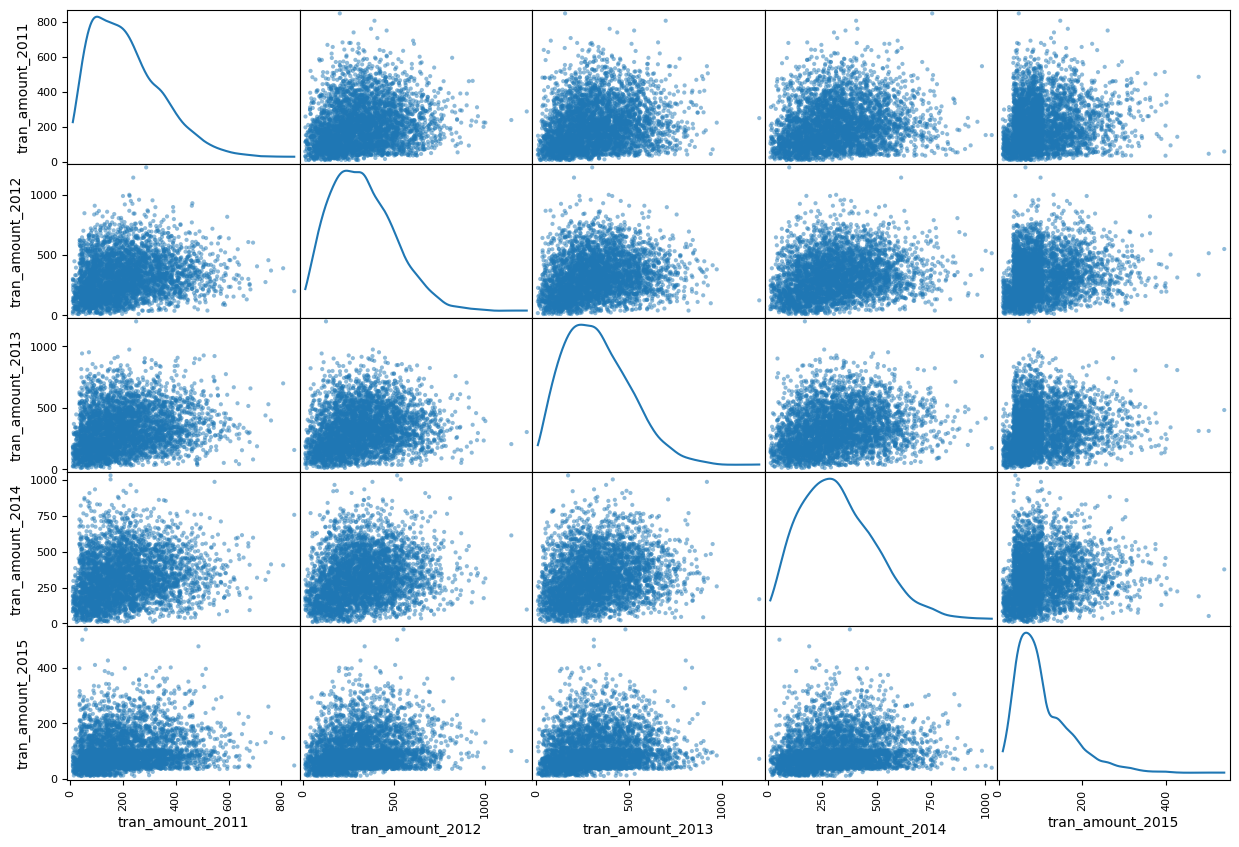

In [10]:
# Matrix scatter plot of the amounts
fig = pd.plotting.scatter_matrix(df_all.loc[:,tran_amounts], diagonal='kde', figsize=(15,10));

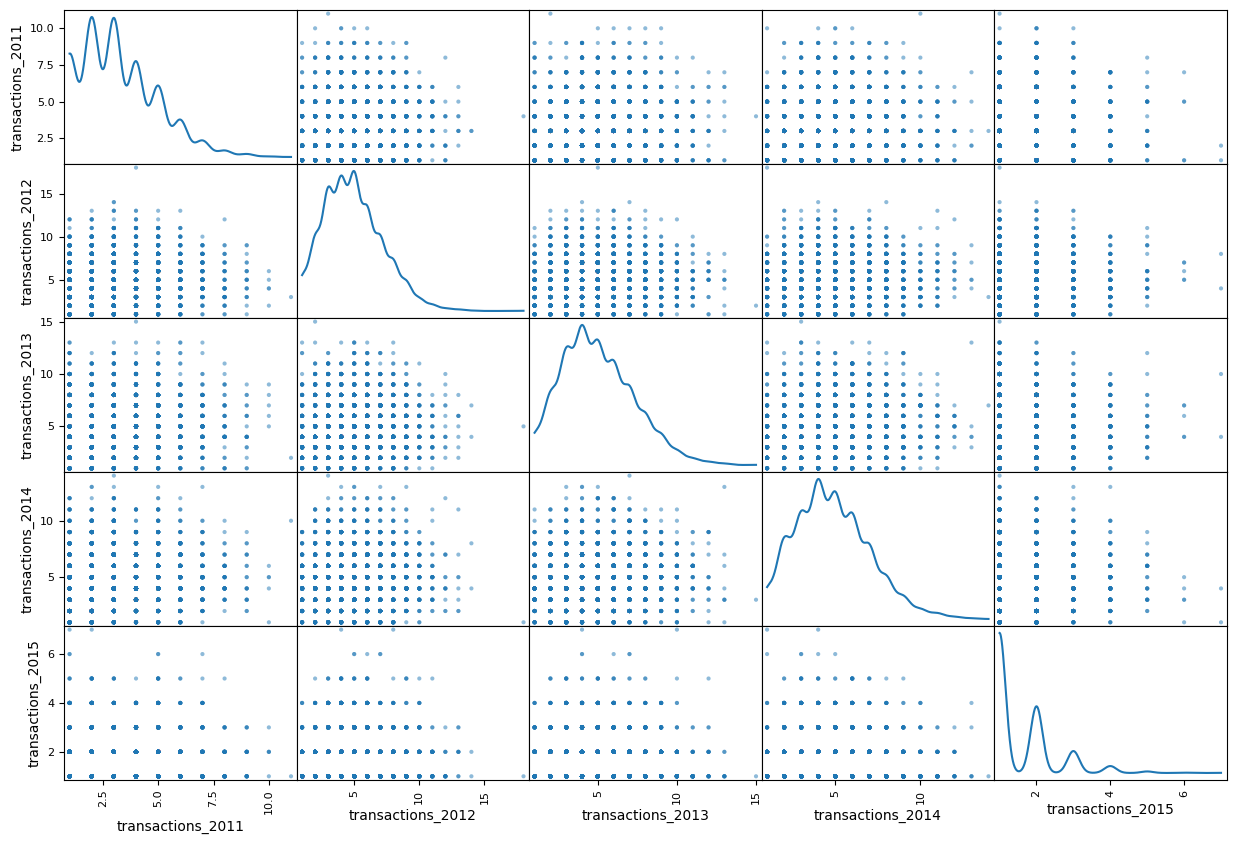

In [11]:
# Matrix scatter plot of the amounts
fig = pd.plotting.scatter_matrix(df_all.loc[:, transactions], diagonal='kde', figsize=(15,10));

In [13]:
# Let us explore the correlation matrix
corrMatrix = df_all.corr(numeric_only=True)
print(corrMatrix)

                   tran_amount_2011  tran_amount_2012  tran_amount_2013  \
tran_amount_2011           1.000000          0.191690          0.191762   
tran_amount_2012           0.191690          1.000000          0.212220   
tran_amount_2013           0.191762          0.212220          1.000000   
tran_amount_2014           0.184938          0.225386          0.234322   
tran_amount_2015           0.144635          0.171480          0.143903   
transactions_2011          0.937707          0.106843          0.114777   
transactions_2012          0.119100          0.936838          0.126933   
transactions_2013          0.115389          0.119156          0.935928   
transactions_2014          0.109806          0.127952          0.145667   
transactions_2015          0.052859          0.078034          0.041289   

                   tran_amount_2014  tran_amount_2015  transactions_2011  \
tran_amount_2011           0.184938          0.144635           0.937707   
tran_amount_2012      

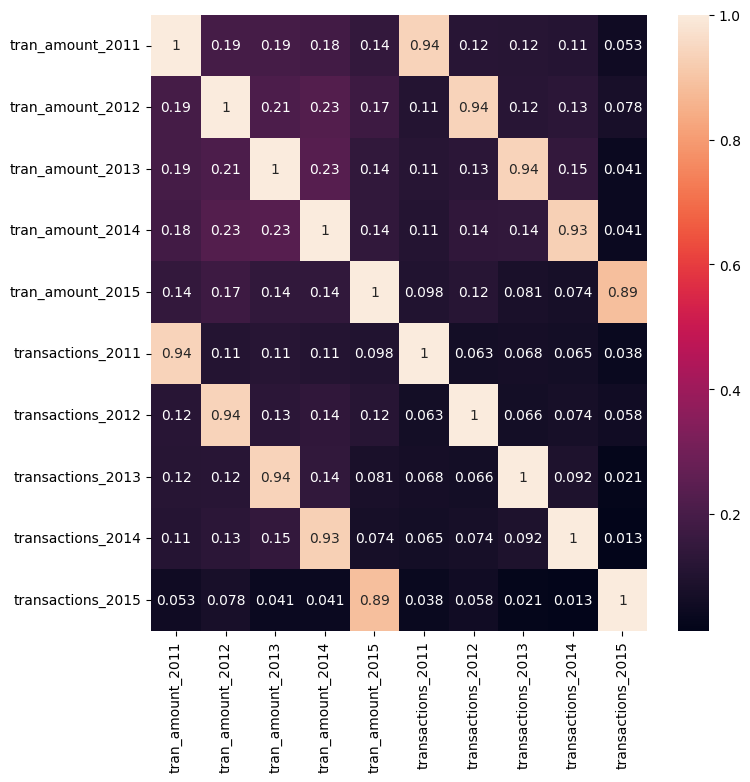

In [14]:
fig = plt.figure(1,figsize=(8, 8))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Clustering of variables

Clustering is one of those tools that do not imply pairs (X,y), but only a collection of {x}.

#### We filter customers of interest and select the variables (important *)

In [15]:
#  Filter data to set the final problem
id_min = 'CS1112'
id_max = 'CS9000'

nom_vars = ['tran_amount_2011', 'tran_amount_2012', 'tran_amount_2013', 'tran_amount_2014', 'tran_amount_2015',
            'transactions_2011', 'transactions_2012', 'transactions_2013', 'transactions_2014', 'transactions_2015']

rows_sel = ((df_all.customer_id >= id_min)  &  (df_all.customer_id <= id_max))
df = df_all.loc[rows_sel, nom_vars].copy()

print('Dataframe df for clustering analysis: ')
df

Dataframe df for clustering analysis: 


,tran_amount_2011,tran_amount_2012,tran_amount_2013,tran_amount_2014,tran_amount_2015,transactions_2011,transactions_2012,transactions_2013,transactions_2014,transactions_2015
0,153.0,516.0,173.0,1029.0,40.0,2.0,7.0,3.0,13.0,1.0
2,153.0,536.0,414.0,1001.0,47.0,2.0,7.0,6.0,11.0,1.0
3,547.0,380.0,921.0,984.0,101.0,7.0,5.0,13.0,13.0,1.0
5,229.0,171.0,378.0,963.0,45.0,3.0,3.0,6.0,12.0,1.0
9,94.0,335.0,313.0,932.0,104.0,2.0,5.0,4.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...
6790,54.0,250.0,157.0,12.0,69.0,1.0,5.0,4.0,1.0,1.0
6791,119.0,244.0,170.0,12.0,69.0,2.0,5.0,3.0,1.0,1.0
6792,207.0,289.0,51.0,12.0,61.0,4.0,7.0,2.0,1.0,1.0
6796,105.0,74.0,142.0,10.0,83.0,2.0,2.0,3.0,1.0,2.0


In [16]:
# Let us normalize the data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(df)
Xnorm = scaler.transform(df)

In [17]:
pdist = hc.distance.pdist(df.corr().values)
linkage = hc.linkage(pdist, method='complete')

In [18]:
pdist = hc.distance.pdist(df.transpose(),metric='correlation')
linkage = hc.linkage(pdist, method='complete')

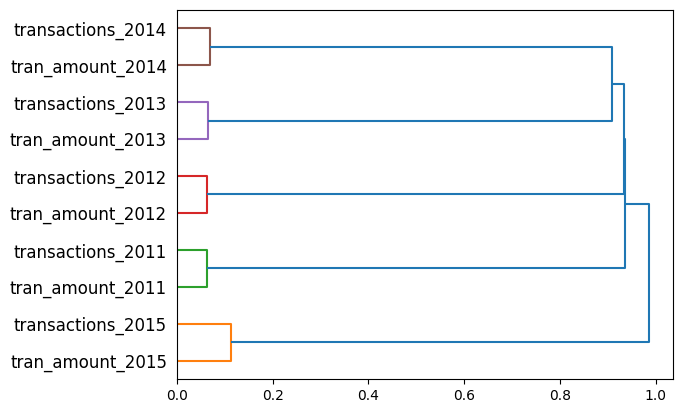

In [19]:
fig=hc.dendrogram(linkage, labels=df.columns, orientation='right')
plt.show()

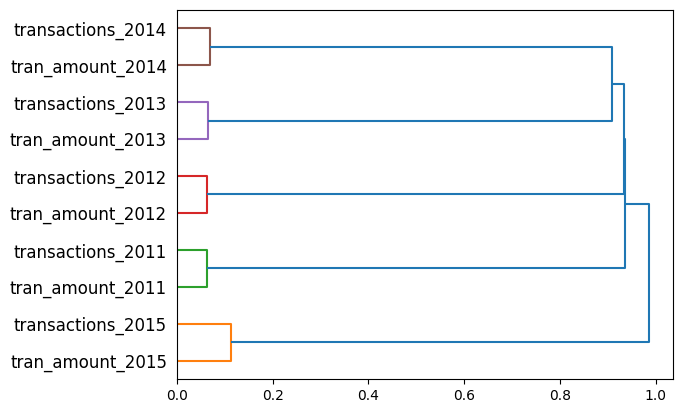

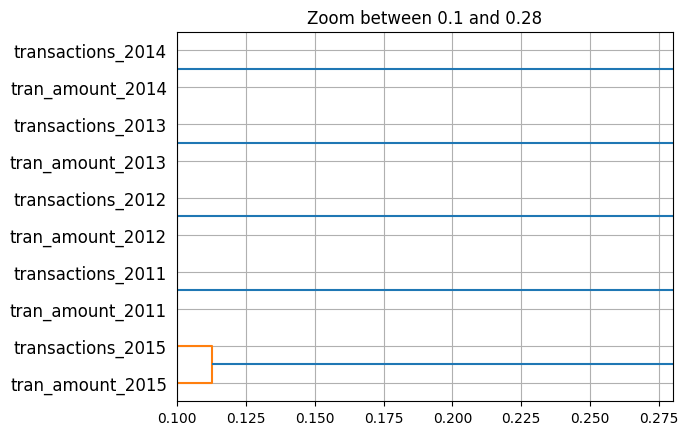

In [20]:
fig=hc.dendrogram(linkage, labels=df.columns, orientation='right')
plt.show()

#useful for zooming
xmin = 0.1
xmax = 0.28
fig=hc.dendrogram(linkage, labels=df.columns, orientation='right')
plt.xlim([xmin, xmax])
plt.title(f'Zoom between {xmin} and {xmax}')
plt.grid()
plt.show()

## Clustering of observations

#### We filter customers of interest and select the variables (important *)

In [21]:
#  Filter data to set the final problem
id_min = 'CS1112'
id_max = 'CS9000'

nom_vars = ['tran_amount_2011', 'tran_amount_2012', 'tran_amount_2013', 'tran_amount_2014', 'tran_amount_2015']

rows_sel = ((df_all.customer_id >= id_min)  &  (df_all.customer_id <= id_max))
df = df_all.loc[rows_sel, nom_vars].copy()

print('Dataframe df for clustering analysis: ')
df

Dataframe df for clustering analysis: 


,tran_amount_2011,tran_amount_2012,tran_amount_2013,tran_amount_2014,tran_amount_2015
0,153.0,516.0,173.0,1029.0,40.0
2,153.0,536.0,414.0,1001.0,47.0
3,547.0,380.0,921.0,984.0,101.0
5,229.0,171.0,378.0,963.0,45.0
9,94.0,335.0,313.0,932.0,104.0
...,...,...,...,...,...
6790,54.0,250.0,157.0,12.0,69.0
6791,119.0,244.0,170.0,12.0,69.0
6792,207.0,289.0,51.0,12.0,61.0
6796,105.0,74.0,142.0,10.0,83.0


In [22]:
# Let us normalize the data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(df)
Xnorm = scaler.transform(df)

X=pd.DataFrame(Xnorm,columns=nom_vars)
print(X)

      tran_amount_2011  tran_amount_2012  tran_amount_2013  tran_amount_2014  \
0             0.170441          0.414754          0.136630          1.000000   
1             0.170441          0.431148          0.338642          0.972522   
2             0.640048          0.303279          0.763621          0.955839   
3             0.261025          0.131967          0.308466          0.935231   
4             0.100119          0.266393          0.253982          0.904809   
...                ...               ...               ...               ...   
3884          0.052443          0.196721          0.123219          0.001963   
3885          0.129917          0.191803          0.134116          0.001963   
3886          0.234803          0.228689          0.034367          0.001963   
3887          0.113230          0.052459          0.110645          0.000000   
3888          0.017878          0.032787          0.220453          0.000000   

      tran_amount_2015  
0             

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Scores: [-427.1273671748353, -322.8950140298289, -276.7798777347851, -244.33336313929877, -221.46296563641081, -201.278068102597, -189.3584777273093, -180.82343876935212, -172.74918768267668, -166.0606142596942, -160.0255890111809, -155.33417531656565, -150.94649836736727, -147.22975192306805, -143.47807811102922, -140.57238430389148, -136.90411537828754, -134.0124063472806, -131.91705363004877]


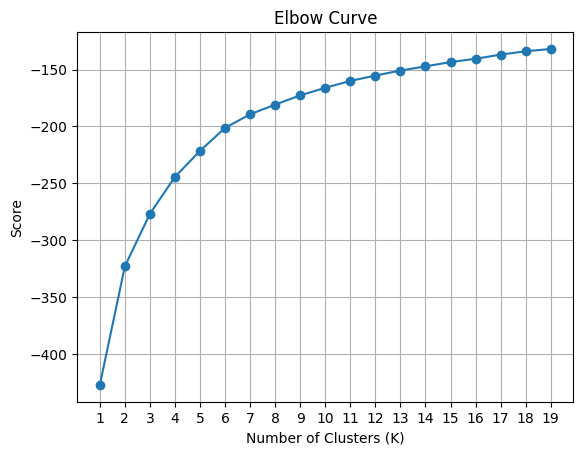

In [23]:
# Let us observe the classification error as a function of the number of clusters
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

print('Scores:', score)
plt.plot(Nc,score,'o-')
plt.xlabel('Number of Clusters (K)')
plt.xticks(Nc)
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.grid()
plt.show()

# Using inertia "Sum of squared distances of samples to their closest cluster center"
# inertia = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]
# print(inertia)
# plt.plot(Nc,inertia,'o-')

In [24]:
# Quantize the input data to 6 clusters
kmeans = KMeans(n_clusters=6).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[0.25076384 0.2797412  0.27868573 0.30295701 0.43864886]
 [0.13090513 0.14059311 0.14900592 0.16782138 0.10963366]
 [0.49821216 0.25832979 0.28853835 0.32074522 0.17612655]
 [0.22491892 0.26296734 0.27510478 0.54728074 0.16798802]
 [0.2415448  0.4632969  0.24117168 0.28474505 0.16271177]
 [0.21014972 0.26287103 0.47805304 0.29892834 0.165317  ]]


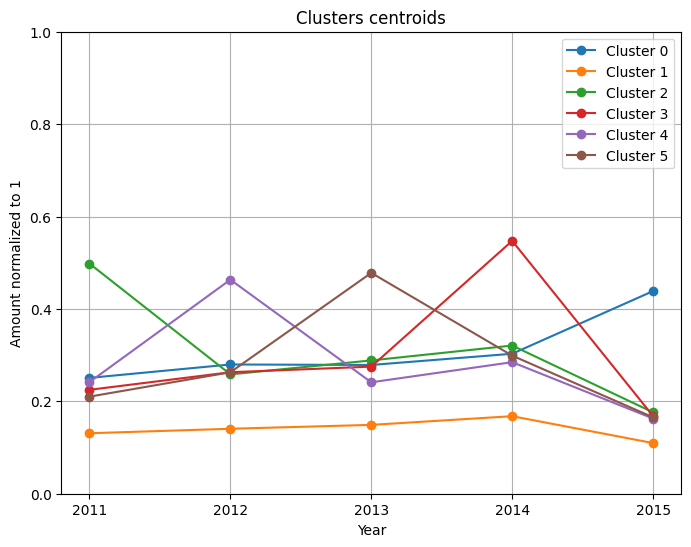

In [25]:
# plot the centers of the clusters
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(centroids.transpose(), 'o-')
ax.set_xlabel('Year')
ax.set_ylabel('Amount normalized to 1')
plt.title('Clusters centroids')
ax.legend(['Cluster %d'%i for i in range(6)])
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['%d'%i for i in range(2011,2016)])
plt.grid()
plt.ylim([0, 1]);